In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [23]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0
!pip install sentencepiece

In [24]:
%matplotlib inline

import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

from transformers import AutoModelForSequenceClassification, AutoTokenizer

from sklearn.metrics import classification_report, f1_score, accuracy_score

os.environ["WANDB_API_KEY"] = "0" # to silence warning

np.random.seed(0)

In [25]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


In [26]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Since we know that the labels for the "entailment" and "contradiction" classes in XLM-Roberta and the input dataset are flipped, we're relabeling these two classes in the training dataset.

In [27]:
train.label.replace([0, 2], [2, 0], inplace=True)

In [28]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, stratify=train.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


train.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [29]:
print("Train data: {} \n".format(train.shape))

print("Validation data: {} \n".format(validation.shape))

Train data: (9696, 6) 

Validation data: (2424, 6) 



In [30]:
# Configuration
EPOCHS = 3
BATCH_SIZE = 64
MAX_LEN = 100
PATIENCE = 1
LEARNING_RATE = 1e-5

In [31]:
model_handle = 'joeddav/xlm-roberta-large-xnli'
tokenizer = AutoTokenizer.from_pretrained(model_handle)

In [32]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask
        }    
    
    return inputs

In [33]:
encoded_train = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)
encoded_validation = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete
Encoding...
Complete


In [34]:
from transformers import TFAutoModel

In [35]:
def build_model(encoder, max_len=50):
    
    tf.random.set_seed(12345) # For reproducibility

    roberta_model = TFAutoModel.from_pretrained(encoder)
    
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    # Extract pretrained embedding vectors
    embedding = roberta_model([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, embed_size)
    # We pass the embedding vectors of only the 'cls' token (at index=0) to the dense layer
    sequence_output = embedding[:,0,:] #shape=(batch_size, embed_size)
   
    # Add a classification layer
    output = Dense(3, activation="softmax")(sequence_output)  
    
    model = Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [36]:
with strategy.scope():
    roberta_model = build_model(model_handle, MAX_LEN)
    roberta_model.summary()

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model_2 (TFXLMRob TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 1024)         0           tfxlm_roberta_model_2[0][0]

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='xlmroberta_best_checkpoint.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

train_history = roberta_model.fit(x=encoded_train, y=train.label.values, validation_data=(encoded_validation, validation.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


152/152 [==============================] - 242s 800ms/step - loss: 0.3828 - accuracy: 0.8615 - val_loss: 0.1971 - val_accuracy: 0.9290

Epoch 00001: val_loss improved from inf to 0.19712, saving model to xlmroberta_best_checkpoint.hdf5
Epoch 2/3
152/152 [==============================] - 31s 201ms/step - loss: 0.1314 - accuracy: 0.9542 - val_loss: 0.2203 - val_accuracy: 0.9253

Epoch 00002: val_loss did not improve from 0.19712
Epoch 00002: early stopping


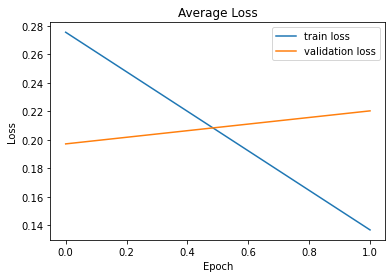

In [38]:
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.title('Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

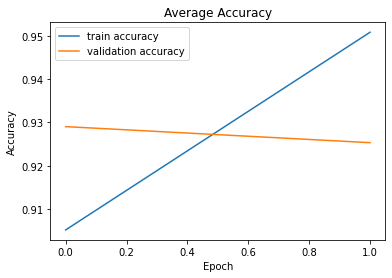

In [39]:
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Classification Report
               precision    recall  f1-score   support

contradiction       0.93      0.93      0.93       835
   entailment       0.95      0.93      0.94       813
      neutral       0.89      0.91      0.90       776

     accuracy                           0.93      2424
    macro avg       0.93      0.93      0.93      2424
 weighted avg       0.93      0.93      0.93      2424



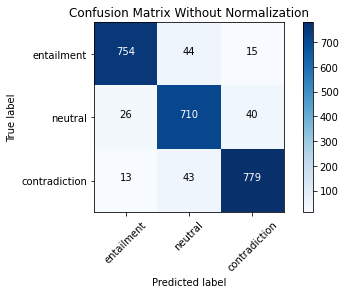

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

validation_predictions = [np.argmax(i) for i in roberta_model.predict(encoded_validation)] #predictions
validation_labels = validation.label.values.tolist() #ground truth labels

cm_plot_labels = ['entailment','neutral', 'contradiction']
cm = confusion_matrix(y_true=validation_labels, y_pred=validation_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Without Normalization')
# plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix With Normalization', normalize=True)

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_labels]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_predictions]
print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))

In [41]:
def accuracy(x):
    return round(float(x[2]/x[1]), 2)*100

validation['predictions'] = validation_predictions

# Calculate the total number of examples per language
lang_counts = validation.language.value_counts().sort_index()

# Calculate the number of correct predictions per language
tp_per_lang = validation[validation['label'] == validation['predictions']].groupby('language').agg({'language': ['count']}).sort_index()

lang_names = lang_counts.index.tolist()
lang_tuples = list(zip(lang_names, lang_counts.values.tolist(), tp_per_lang.iloc[:, 0].values.tolist()))
acc = map(accuracy, lang_tuples)
print("Accuracy of the model per language")
for i, score in enumerate(acc):
    print ("Accuracy of {} is {} ".format(lang_tuples[i][0], score))

Accuracy of the model per language
Accuracy of Arabic is 98.0 
Accuracy of Bulgarian is 100.0 
Accuracy of Chinese is 95.0 
Accuracy of English is 88.0 
Accuracy of French is 98.0 
Accuracy of German is 100.0 
Accuracy of Greek is 97.0 
Accuracy of Hindi is 97.0 
Accuracy of Russian is 100.0 
Accuracy of Spanish is 100.0 
Accuracy of Swahili is 96.0 
Accuracy of Thai is 96.0 
Accuracy of Turkish is 100.0 
Accuracy of Urdu is 97.0 
Accuracy of Vietnamese is 100.0 


In [43]:
roberta_model.load_weights(checkpoint_filepath)

In [44]:
encoded_test = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [46]:
predictions = [np.argmax(i) for i in roberta_model.predict(encoded_test)]

In [47]:
pd.DataFrame(predictions).value_counts()
pd.DataFrame({'id':test.id,
              'prediction':predictions}).to_csv('submission.csv',index=False)